# Introduction to Physical Architecture API

**Note**: In this notebook we will use `pandas` dataframes library to construct and visualize tables, **if you don't have pandas installed** in the current environment you may want to do so by running the cell below.

In [ ]:
%pip install pandas

The cell below loads our test model so we could play with it and silences warnings.

In [1]:
import capellambse
import logging
import pandas as pd

logging.getLogger().setLevel(logging.CRITICAL)
path_to_model = "../../../tests/data/melodymodel/5_0/Melody Model Test.aird"
model = capellambse.MelodyModel(path_to_model)

but before we jump into code, lets have a look first at Capella metamodel concerning the Physical Architecture layer (PA).

Things in PA are very similar to what we see in SysML when it comes to `ibd`s (Internal Block Diagrams) - the boxes we see on those are `Part`s that are instanciated from `Block` objects. Same happens in Capella - the boxes we see on `PAB` diagrams are `Parts` that were instanciated from `PhysicalComponent`s. Here also comes the very special difference of Capella - unless you explicitly enable **part re-use**, `PhysicalComponent` will always have only one `Part`. This is the default behavior of Capella. 

Our API should support both cases but at the moment we don't use models with **part re-use** enabled in production yet and so don't test the library against this case. Yet we do implement Parts and support many parts - one component relationship model.

One more issue to mention - rendering PA diagrams outside of Capella was never a high priority so the resulting representations of PABs rendered without Capella are not very accurate at the moment. We hope to improve it soon though. If you still do want to see how it looks like when we render it right now - uncomment the `# diagram` in the cell below

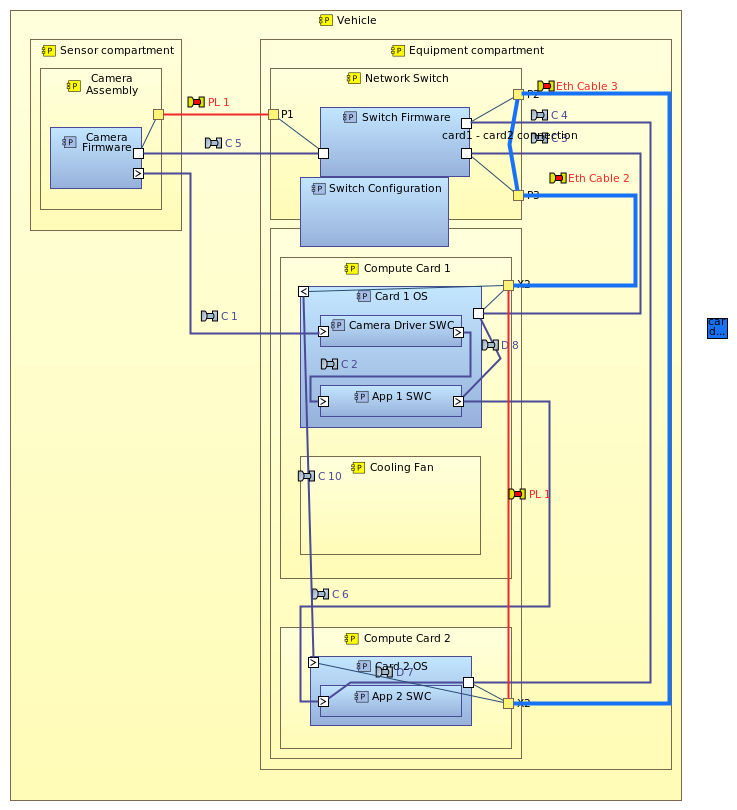

In [2]:
diagram = model.pa.diagrams.by_name("[PAB] A sample vehicle arch")
diagram

## Example 1: List components that are visible on a diagram

To start, let's get all parts on that diagram and turn them into PhysicalComponents.

In [3]:
components_on_diagram = diagram.nodes.by_type("Part").map("type")
components_on_diagram

[0] <PhysicalComponent 'Vehicle' (b327d900-abd2-4138-a111-9ff0684739d8)>
[1] <PhysicalComponent 'Equipment compartment' (3d68852d-fcc0-452c-af12-a2fbe22f81fa)>
[2] <PhysicalComponent 'Server' (9137f463-7497-40c2-b20a-897158fdba9a)>
[3] <PhysicalComponent 'Compute Card 1' (63be604e-883e-41ea-9023-fc74f29906fe)>
[4] <PhysicalComponent 'Card 1 OS' (7b188ad0-0d82-4b2c-9913-45292e537871)>
[5] <PhysicalComponent 'Camera Driver SWC' (74067f56-33bf-47f5-bb8b-f3604097f653)>
[6] <PhysicalComponent 'App 1 SWC' (b80a6fcc-8d35-4675-a2e6-60efcbd61e27)>
[7] <PhysicalComponent 'Cooling Fan' (65e82f3f-c5b7-44c1-bfea-8e20bb0230be)>
[8] <PhysicalComponent 'Compute Card 2' (3a982128-3281-4d37-8838-a6058b7a25d9)>
[9] <PhysicalComponent 'Card 2 OS' (09e19313-c824-467f-9fb5-95ed8b4e2d51)>
[10] <PhysicalComponent 'App 2 SWC' (ca5af12c-5259-4844-aaac-9ca9f84aa90b)>
[11] <PhysicalComponent 'Network Switch' (b51ccc6f-5f96-4e28-b90e-72463a3b50cf)>
[12] <PhysicalComponent 'Switch Firmware' (c78b5d7c-be0c-4ed4-9d12-d447cb39304e)>
[13] <PhysicalComponent 'Switch Configuration' (23c47b69-7352-481d-be88-498fb351adbe)>
[14] <PhysicalComponent 'Sensor compartment' (3f416925-9d8a-4e9c-99f3-e912efb23d2f)>
[15] <PhysicalComponent 'Camera Assembly' (5bfc516b-c20d-4007-9a38-5ba0e889d0a4)>
[16] <PhysicalComponent 'Camera Firmware' (db2d86d7-48ee-478b-a6fc-d6387ab0032e)>

We could also get all components across the entire PA layer by doing `model.pa.all_components`, but we will not go there in this example.

We can review any single component from that list above:

In [4]:
components_on_diagram[7]

allocated_functions,(Empty list)
applied_property_value_groups,(Empty list)
applied_property_values,(Empty list)
components,(Empty list)
constraints,(Empty list)
deployed_components,(Empty list)
deploying_components,Backreference to PhysicalComponent - omitted: can be slow to compute. Display this property directly to show.
description,
diagrams,(Empty list)
exchanges,(Empty list)
filtering_criteria,(Empty list)


However we may need just a few of those attributes in a view.

Now that we have a list of components lets collect some of the attributes of interest in a table. To keep it simple we'll introduce an attribute extractor function that will turn fields of interest into a nice dictionary.

In [5]:
def extract_attrs_of_interest(component):
    return dict(
        name=component.name,
        nature=component.nature,
        kind=component.kind,
        components="; ".join([cmp.name for cmp in component.components])
    )

We can then apply that extractor function to our list of components and use `pandas` to display it for us in a tabular form:

In [6]:
pd.DataFrame(list(map(extract_attrs_of_interest, components_on_diagram)))

,name,nature,kind,components
0,Vehicle,NODE,SOFTWARE_DEPLOYMENT_UNIT,Equipment compartment; Sensor compartment
1,Equipment compartment,NODE,FACILITIES,Server; Network Switch
2,Server,NODE,HARDWARE,Compute Card 1; Compute Card 2
3,Compute Card 1,NODE,HARDWARE,Card 1 OS; Cooling Fan
4,Card 1 OS,BEHAVIOR,SERVICES,Camera Driver SWC; App 1 SWC
5,Camera Driver SWC,BEHAVIOR,SOFTWARE,
6,App 1 SWC,BEHAVIOR,SOFTWARE,
7,Cooling Fan,NODE,HARDWARE,
8,Compute Card 2,NODE,HARDWARE,Card 2 OS
9,Card 2 OS,BEHAVIOR,SOFTWARE,App 2 SWC


## Example 2: Create HW-SW allocation table

Now let's assume that components of "Node" nature are hardware things and "Behavior" corresponds to software components. Assuming that, let's identify leaf hardware components (lowest replaceable units), and for each of those indicate which software components they have.

To get there, let's first filter out the list of components of "Node" nature that have at least one subcomponent of "Behavior" nature. We'll use the `.filter` method of our object list. To use that method we'll need to provide a function or lambda that determines whether an object should be selected. We can also make use of the implicit "truthiness" of non-empty list attributes:

In [7]:
cmps = model.pa.all_components[1:].by_nature("NODE")
# Note: the above [1:] assumes that 0th component is the root component and is not of interest (+ see issue #41)
cmps_with_sw = cmps.filter(lambda i: i.components.by_nature("BEHAVIOR"))
cmps_with_sw

[0] <PhysicalComponent 'Sub PC' (793e6da2-d019-4716-a5c5-af8ad550ca5e)>
[1] <PhysicalComponent 'Deploy Sub PC' (8a6c6ec9-095d-4d8b-9728-69bc79af5f27)>
[2] <PhysicalComponent 'Compute Card 1' (63be604e-883e-41ea-9023-fc74f29906fe)>
[3] <PhysicalComponent 'Compute Card 2' (3a982128-3281-4d37-8838-a6058b7a25d9)>
[4] <PhysicalComponent 'Network Switch' (b51ccc6f-5f96-4e28-b90e-72463a3b50cf)>
[5] <PhysicalComponent 'Camera Assembly' (5bfc516b-c20d-4007-9a38-5ba0e889d0a4)>
[6] <PhysicalComponent 'Computer' (b14ff190-9198-4d05-95db-b121c11e9f17)>
[7] <PhysicalComponent 'ISP Network' (221cef9f-0582-419c-b67e-96ddb678dd4c)>

For sure we could come to the above list filtering by `kind` attribute, however in practice not all projects strictly use the `kind` attribute / it needs manual setting and maintenance and therefore is a bit less reliable.

Our next stop is to list the SW components of those HW components. As SW components may be nested (i.e. apps on OS or partitions, etc.) we would simply "flatten" that hierarchy. We can create function `get_sw_components` that would recursively crawl down the SW components tree and give us back a flat list and test it on one component.

In [8]:
def get_sw_components(sw_component):
    subcmp = sw_component.components.by_nature("BEHAVIOR")
    for cmp in subcmp:
        subcmp += get_sw_components(cmp)
    return subcmp

get_sw_components(cmps_with_sw.by_name("Compute Card 1"))

[0] <PhysicalComponent 'Card 1 OS' (7b188ad0-0d82-4b2c-9913-45292e537871)>
[1] <PhysicalComponent 'Camera Driver SWC' (74067f56-33bf-47f5-bb8b-f3604097f653)>
[2] <PhysicalComponent 'App 1 SWC' (b80a6fcc-8d35-4675-a2e6-60efcbd61e27)>

Let's apply the `get_sw_components` function to the complete list of components with SW, `cmps_with_sw`, and turn the results into a table. In this table we'll serialize SW components into a semicolon-separated string:

In [9]:
def describe_hw_component_sw_allocations(hw_component):
    return dict(
        hardware_component=hw_component.name,
        deployed_sw_components="; ".join(i.name for i in get_sw_components(hw_component))
    )

df = pd.DataFrame(list(map(describe_hw_component_sw_allocations, cmps_with_sw)))
df

,hardware_component,deployed_sw_components
0,Sub PC,PC 16
1,Deploy Sub PC,PC 17
2,Compute Card 1,Card 1 OS; Camera Driver SWC; App 1 SWC
3,Compute Card 2,Card 2 OS; App 2 SWC
4,Network Switch,Switch Firmware; Switch Configuration
5,Camera Assembly,Camera Firmware
6,Computer,Mail client
7,ISP Network,Mail server


To complete the picture, we could also list all HW components that don't have software (so that a sanity check could be performed):

In [10]:
cmps_without_sw = cmps.filter(lambda i: not i.components.by_nature("BEHAVIOR"))
cmps_without_sw

[0] <PhysicalComponent 'PC 1' (8a6d68c8-ac3d-4654-a07e-ada7adeed09f)>
[1] <PhysicalComponent 'PC 3' (f5d7980d-e1e9-4515-8bb0-be7e80ac5839)>
[2] <PhysicalComponent 'Vehicle' (a2c7f619-b38a-4b92-94a5-cbaa631badfc)>
[3] <PhysicalComponent 'Vehicle' (b327d900-abd2-4138-a111-9ff0684739d8)>
[4] <PhysicalComponent 'Equipment compartment' (3d68852d-fcc0-452c-af12-a2fbe22f81fa)>
[5] <PhysicalComponent 'Server' (9137f463-7497-40c2-b20a-897158fdba9a)>
[6] <PhysicalComponent 'Cooling Fan' (65e82f3f-c5b7-44c1-bfea-8e20bb0230be)>
[7] <PhysicalComponent 'Sensor compartment' (3f416925-9d8a-4e9c-99f3-e912efb23d2f)>
[8] <PhysicalComponent 'Router' (69bfe48d-78f0-4b1f-89c0-917dc2339ff9)>
[9] <PhysicalComponent 'PA 1' (a0847e9c-8b82-407d-8143-e908e2db97a1)>